We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [ ]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

Lets download the dataset

In [ ]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2022-09-01 10:06:39--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

loan_train.csv      100%[===================>]  22.56K  --.-KB/s    in 0.09s   

2022-09-01 10:06:40 (262 KB/s) - ‘loan_train.csv’ saved [23101/23101]



Load Data From CSV File

In [ ]:
df = pd.read_csv('loan_train.csv')
df.head(8)

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male
5,7,7,PAIDOFF,1000,30,9/9/2016,10/8/2016,36,college,male
6,8,8,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,male
7,9,9,PAIDOFF,800,15,9/10/2016,9/24/2016,26,college,male


In [ ]:
df.shape

(346, 10)

Convert to date time object

In [ ]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


Data visualization and pre-processing: Let’s see how many of each class is in our data set

In [ ]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection

Lets plot some columns to underestand data better:

In [ ]:
# notice: installing seaborn might takes a few minutes
#!conda install -c anaconda seaborn -y

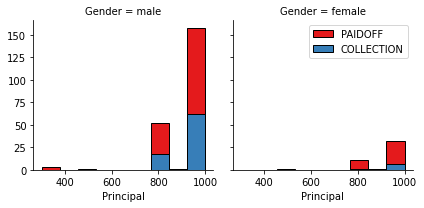

In [ ]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

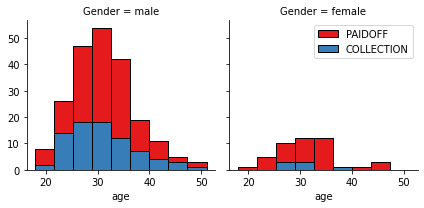

In [ ]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing: Feature selection/extraction

Lets look at the day of the week people get the loan

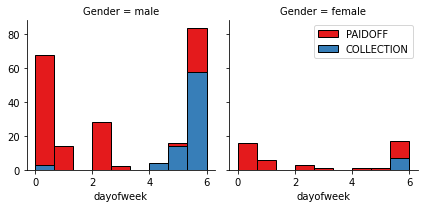

In [ ]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4

In [ ]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


# Convert Categorical features to numerical values

Lets look at gender:

In [ ]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan

Lets convert male to 0 and female to 1:

In [ ]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


How about education?

In [ ]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

Feature before Encoding

In [ ]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


Use one encoding technique to convert categorical variables to binary variables and append them to the featured Data Frame

In [ ]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


# Feature selection

Lets defind feature sets, X:

In [ ]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?

In [ ]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

# Normalize Data
Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [ ]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classifications
# K Nearest Neighbor(KNN)

Building model using KNN, finding the best k and accuracy evaluation

Test set Accuracy at k= 1 :  0.625
Test set Accuracy at k= 2 :  0.582089552238806
Test set Accuracy at k= 3 :  0.726027397260274
Test set Accuracy at k= 4 :  0.6666666666666666
Test set Accuracy at k= 5 :  0.7733333333333333
Test set Accuracy at k= 6 :  0.7246376811594203
Test set Accuracy at k= 7 :  0.7916666666666666
Test set Accuracy at k= 8 :  0.7428571428571429
Test set Accuracy at k= 9 :  0.7702702702702703


Text(0, 0.5, 'Testing Accuracy')

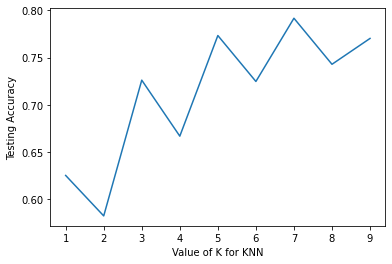

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import jaccard_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline

k_range = range(1, 10)
accuracy_score = []
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.23)
for k in k_range:
    KNN = KNeighborsClassifier(n_neighbors = k).fit(X_train, y_train)

    knn_yhat = KNN.predict(X_test)
    print("Test set Accuracy at k=", k, ": ", jaccard_score(y_test, knn_yhat, pos_label="PAIDOFF"))
    accuracy_score.append(jaccard_score(y_test, knn_yhat, pos_label="PAIDOFF"))


plt.plot(k_range, accuracy_score)
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')

K = 7 is the best let's try it !

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
# perform the test
KNN = KNeighborsClassifier(n_neighbors = 7).fit(X_train, y_train)
KNN

KNeighborsClassifier(n_neighbors=7)

# Decision Tree
Building model using Decision Tree, finding the best k and accuracy evaluation

In [ ]:
# findinng the best depth level
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_score

# Compare accuracy result for depth = 3, 4 and 5
d_range = range(3, 6)
f1 = []
ja = []
for d in d_range:
    DT = DecisionTreeClassifier(criterion="entropy", max_depth=d)
    DT.fit(X_train, y_train)
    dt_yhat = DT.predict(X_test)
    f1.append(f1_score(y_test, dt_yhat, average='weighted'))
    ja.append(jaccard_score(y_test, dt_yhat,pos_label="PAIDOFF"))

result = pd.DataFrame(f1, index=['d=3','d=4', 'd=5'])
result.columns = ['F1-score']
result.insert(loc=1, column='Jacard', value=ja)
result.columns.name = "Depth"
result

Depth,F1-score,Jacard
d=3,0.659752,0.762500
d=4,0.659752,0.762500
d=5,0.658946,0.721519


Depth = 4 is the best let's try it !

In [ ]:
from sklearn.tree import DecisionTreeClassifier

DT = DecisionTreeClassifier(criterion="entropy", max_depth=4)

DT.fit(X_train, y_train)
DT

DecisionTreeClassifier(criterion='entropy', max_depth=4)

# Support Vector Machine
Building model using SVM, finding the best k and accuracy evaluation

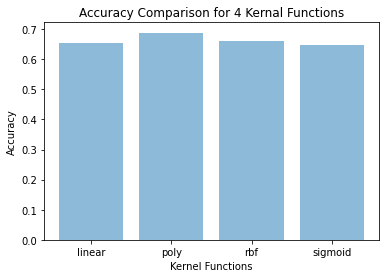

In [ ]:
from sklearn import svm
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score


import matplotlib.pyplot as plt
%matplotlib inline

func_list = ['linear', 'poly', 'rbf', 'sigmoid']
accuracy_score = []

for func in func_list:
    SVM = svm.SVC(kernel=func)
    SVM.fit(X_train, y_train)
    svm_yhat = SVM.predict(X_test)
    accuracy_score.append(f1_score(y_test, svm_yhat, average='weighted'))
    

import numpy as np
import matplotlib.pyplot as plt
y_pos = np.arange(len(func_list))
plt.bar(y_pos, accuracy_score, align='center', alpha=0.5)
plt.xticks(y_pos, func_list)
plt.ylabel('Accuracy')
plt.xlabel('Kernel Functions')
plt.title('Accuracy Comparison for 4 Kernal Functions')
plt.show()

poly is The found best kernel function. So, let's try it

In [ ]:
from sklearn import svm

SVM = svm.SVC(kernel='poly')

SVM.fit(X_train, y_train)
SVM

SVC(kernel='poly')

# Model Evaluation using Test set

In [ ]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score

First, download and load the test set:

In [ ]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2022-09-01 11:48:01--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

loan_test.csv       100%[===================>]   3.56K  --.-KB/s    in 0s      

2022-09-01 11:48:01 (422 MB/s) - ‘loan_test.csv’ saved [3642/3642]



Load Test set for evaluation

In [ ]:
test_df = pd.read_csv('loan_test.csv')
test_df.head(8)

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male
5,37,37,PAIDOFF,700,15,9/11/2016,9/25/2016,33,High School or Below,male
6,38,38,PAIDOFF,1000,15,9/11/2016,9/25/2016,24,college,male
7,48,48,PAIDOFF,1000,30,9/11/2016,10/10/2016,32,Bechalor,male


# 1. Data pre-processing and selection
we are going to do the same thins as loan_train.csv data sets above.

In [ ]:
test_df = pd.read_csv('loan_test.csv')
# convert date time
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
# evaulate weekend field
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
# convert male to 0 and female to 1
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
# work out education level
test_feature = test_df[['Principal','terms','age','Gender','weekend']]
test_feature = pd.concat([test_feature,pd.get_dummies(test_df['education'])], axis=1)
test_feature.drop(['Master or Above'], axis = 1,inplace=True)
# Testing feature
X_loan_test = test_feature
# normalize the test data
X_loan_test = preprocessing.StandardScaler().fit(X_loan_test).transform(X_loan_test)
# and target result
y_loan_test = test_df['loan_status'].values
y_loan_test[0:5]
print (X_loan_test[0:5])
print (X_loan_test.shape)
print (y_loan_test[0:5])
print (y_loan_test.shape)

[[ 0.49362588  0.92844966  3.05981865  1.97714211 -1.30384048  2.39791576
  -0.79772404 -0.86135677]
 [-3.56269116 -1.70427745  0.53336288 -0.50578054  0.76696499 -0.41702883
  -0.79772404 -0.86135677]
 [ 0.49362588  0.92844966  1.88080596  1.97714211  0.76696499 -0.41702883
   1.25356634 -0.86135677]
 [ 0.49362588  0.92844966 -0.98251057 -0.50578054  0.76696499 -0.41702883
  -0.79772404  1.16095912]
 [-0.66532184 -0.78854628 -0.47721942 -0.50578054  0.76696499  2.39791576
  -0.79772404 -0.86135677]]
(54, 8)
['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']
(54,)


Jaccard setup

In [ ]:
from sklearn.metrics import jaccard_score

# KNN
knn_yhat = KNN.predict(X_loan_test)
jc1 = round(jaccard_score(y_loan_test, knn_yhat, pos_label="PAIDOFF"), 2)
# DT
dt_yhat = DT.predict(X_loan_test)
jc2 = round(jaccard_score(y_loan_test, dt_yhat, pos_label="PAIDOFF"), 2)
# SVM
svm_yhat = SVM.predict(X_loan_test)
jc3 = round(jaccard_score(y_loan_test, svm_yhat, pos_label="PAIDOFF"), 2)


list_jc = [jc1, jc2, jc3]
list_jc

[0.64, 0.75, 0.72]

F1-score setup

In [ ]:
from sklearn.metrics import f1_score
# KNN
fs1 = round(f1_score(y_loan_test, knn_yhat, average='weighted'), 2)
# DT 
fs2 = round(f1_score(y_loan_test, dt_yhat, average='weighted'), 2)
# SVM
fs3 = round(f1_score(y_loan_test, svm_yhat, average='weighted'), 2)


list_fs = [fs1, fs2, fs3]
list_fs

[0.6, 0.67, 0.62]

# Report

In [ ]:
df = pd.DataFrame(list_jc, index=['KNN','Decision Tree','SVM'])
df.columns = ['Jaccard']
df.insert(loc=1, column='F1-score', value=list_fs)
#df.insert(loc=2, column='LogLoss', value=list_ll)
df.columns.name = 'Algorithm'
df

Algorithm,Jaccard,F1-score
KNN,0.64,0.60
Decision Tree,0.75,0.67
SVM,0.72,0.62
